## Nikolaos Athanasopoulos

# Assignment: Risk predicition of criminal re-offense


In [978]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [979]:
FILENAME_DATASET = 'reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [980]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [981]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

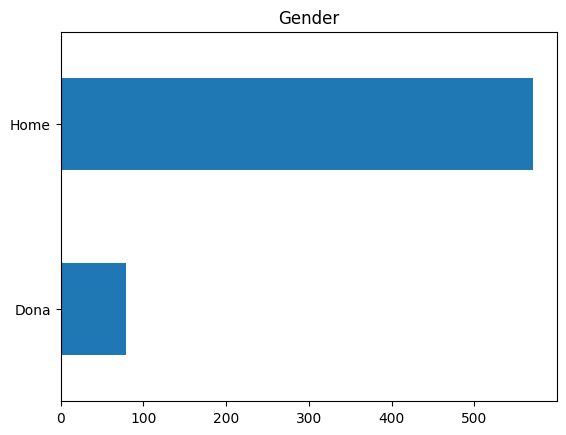

In [982]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

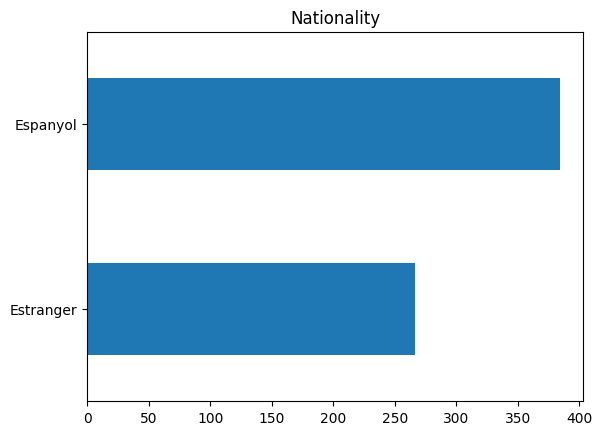

In [983]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

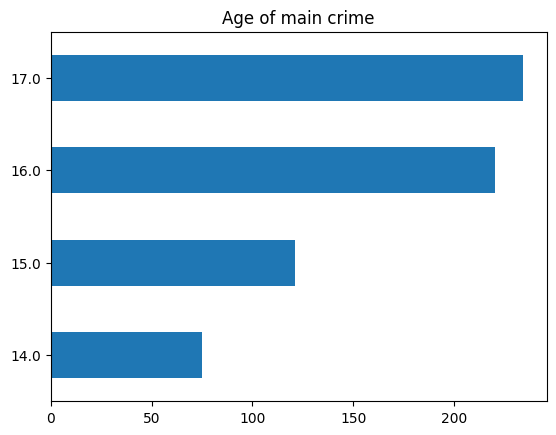

In [984]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

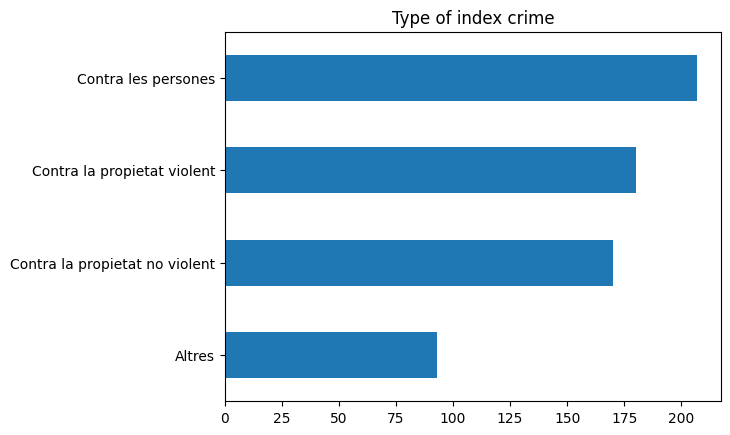

In [985]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

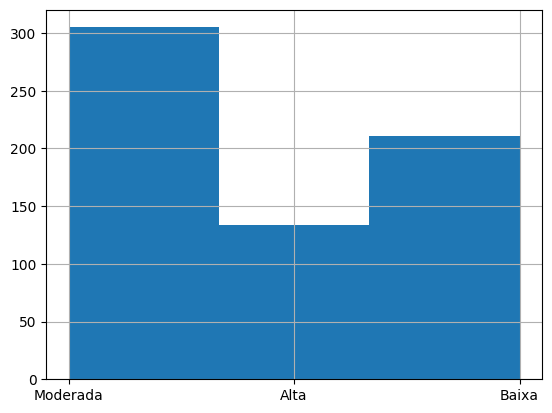

In [986]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

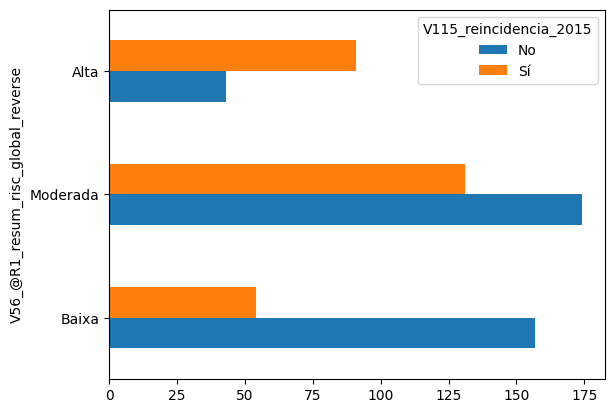

In [987]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [988]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015,No,Sí,recidivism_rate
V56_@R1_resum_risc_global_reverse,,,
Baixa,157,54,0.255924
Moderada,174,131,0.429508
Alta,43,91,0.679104


### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [989]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [990]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

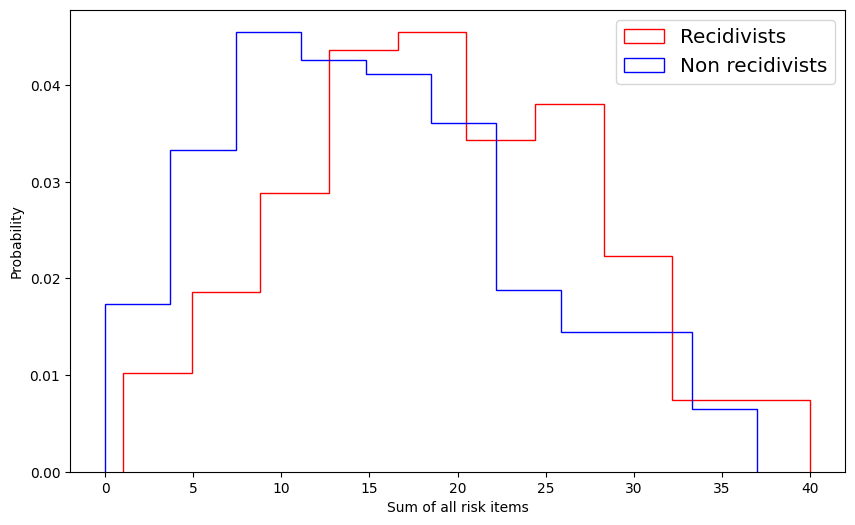

In [991]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [992]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

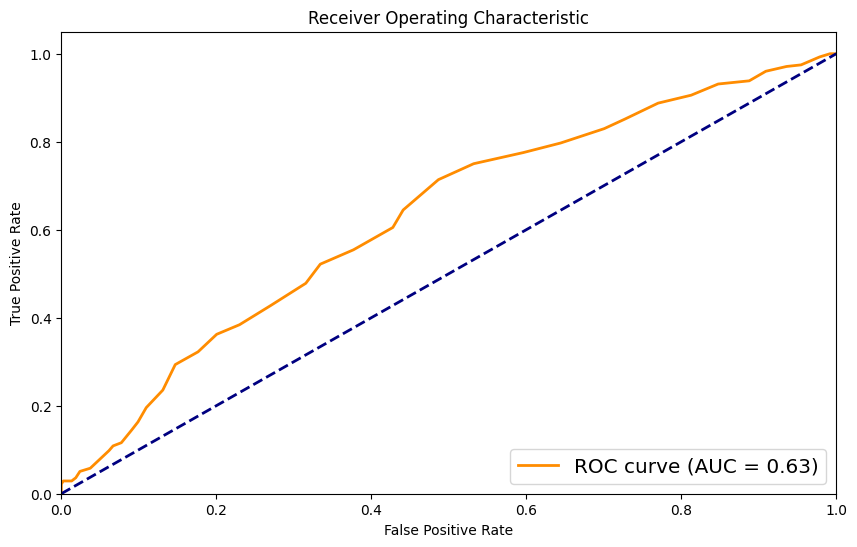

In [993]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [994]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [995]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [996]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [997]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

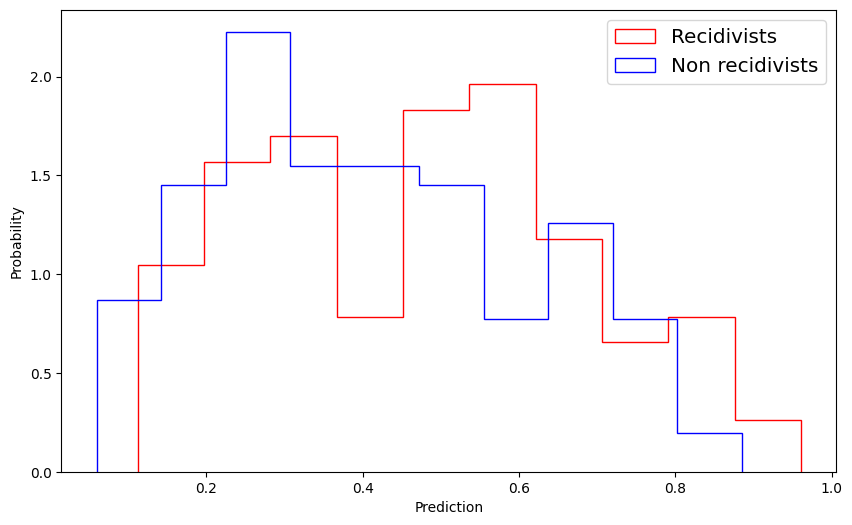

In [998]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

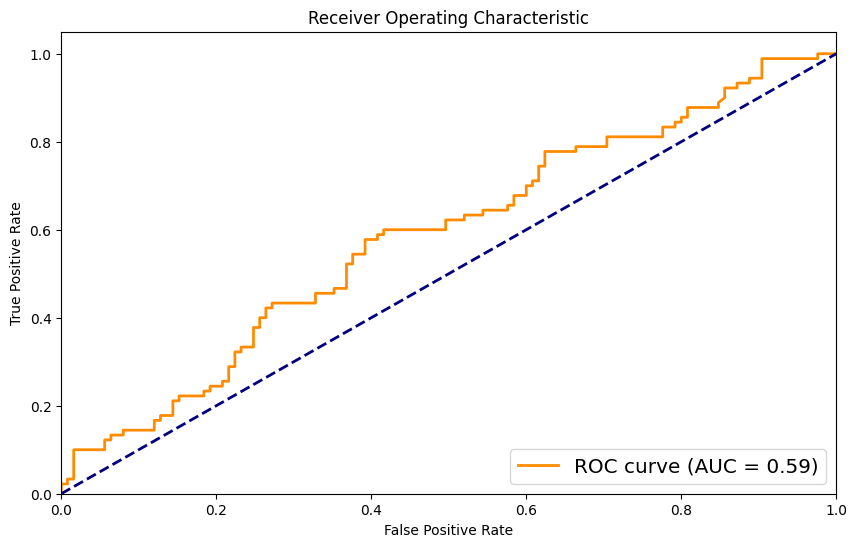

In [999]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [1000]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [1001]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [1002]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

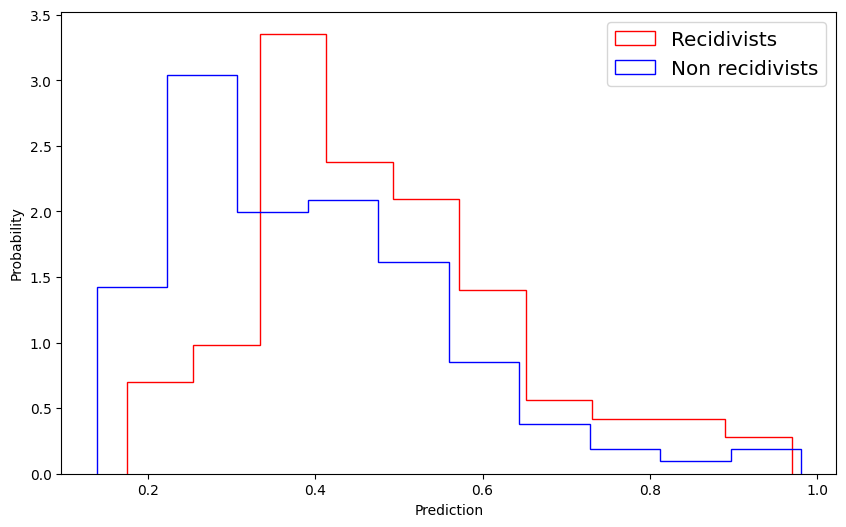

In [1003]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

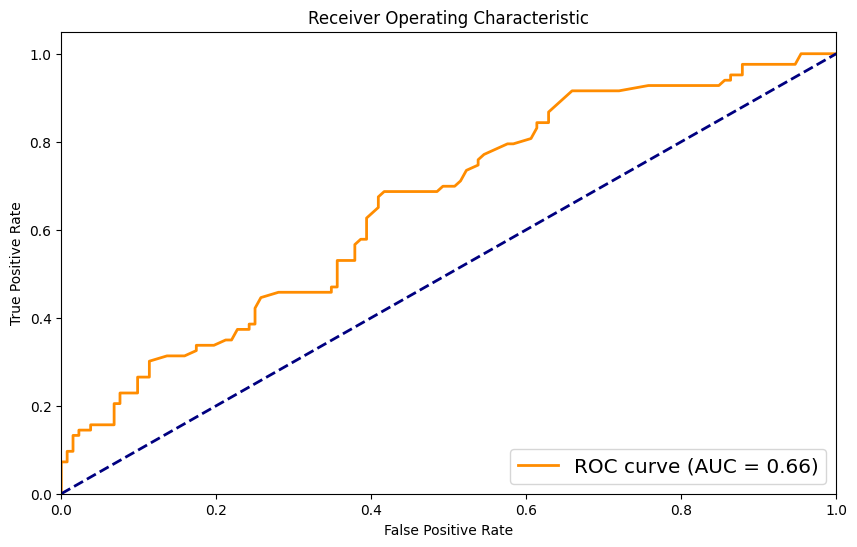

In [862]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [863]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [864]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [865]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

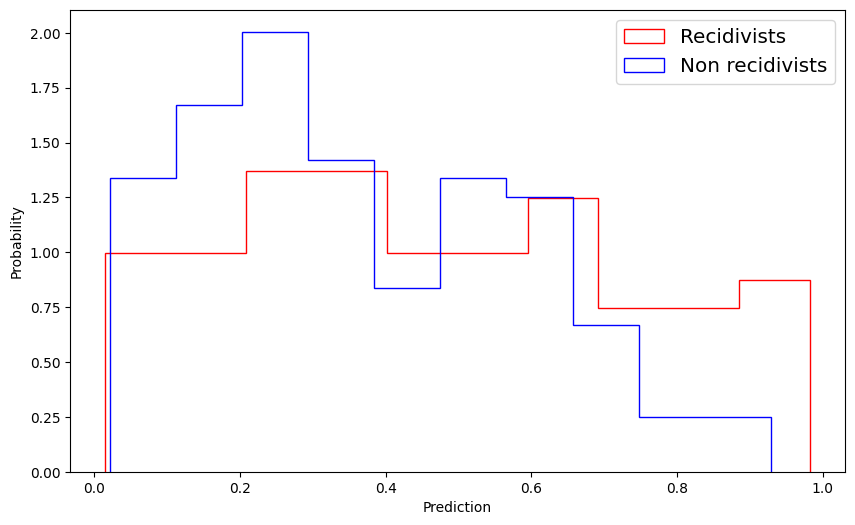

In [866]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

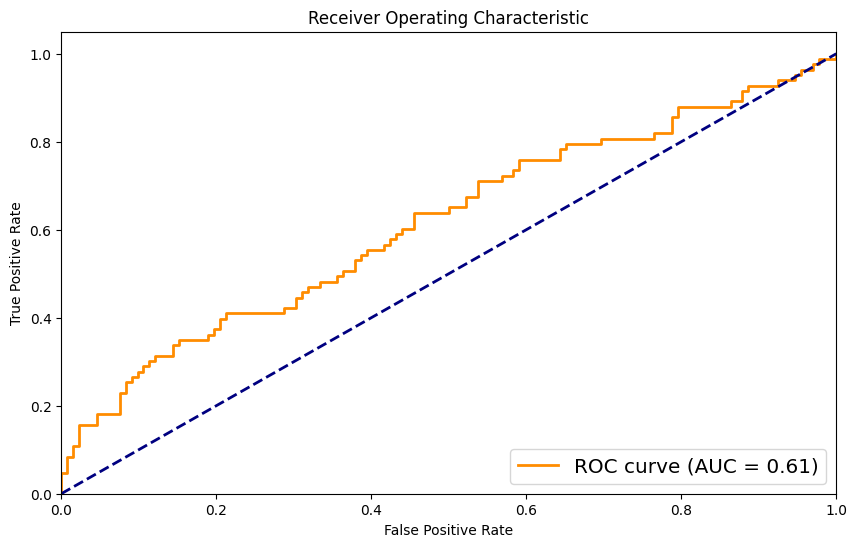

In [867]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [868]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe,Dona,Home
V115_reincidencia_2015,,
No,0.759494,0.549912
Sí,0.240506,0.450088


In [869]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger,Espanyol,Estranger
V115_reincidencia_2015,,
No,0.632812,0.492481
Sí,0.367188,0.507519


# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [870]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe,Dona,Home
V56_@R1_resum_risc_global_reverse,,
Alta,0.116667,0.114650
Baixa,0.433333,0.417197
Moderada,0.450000,0.468153


In [871]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger
V56_@R1_resum_risc_global_reverse,,
Alta,0.106996,0.129771
Baixa,0.423868,0.412214
Moderada,0.469136,0.458015


## Overall SAVRY score and fairness

In [872]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 19.12
Average SAVRY score of women non-recidivist: 15.67


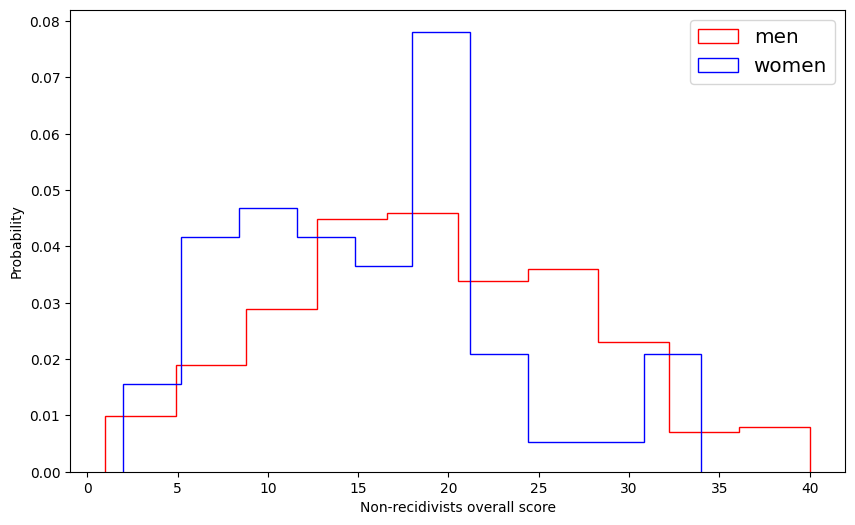

In [873]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [874]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 18.89
Average SAVRY score of foreigner non-recidivist: 16.51


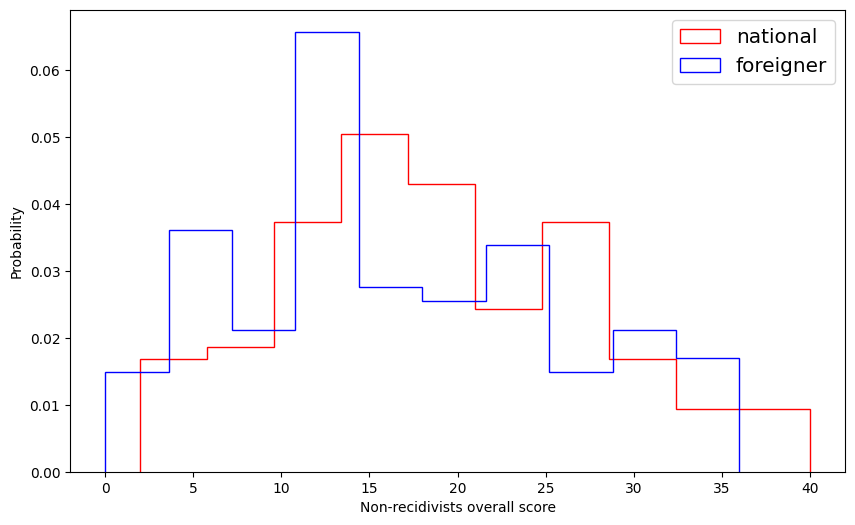

In [875]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [876]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.42
Average predicted probability of women non-recidivist: 0.24


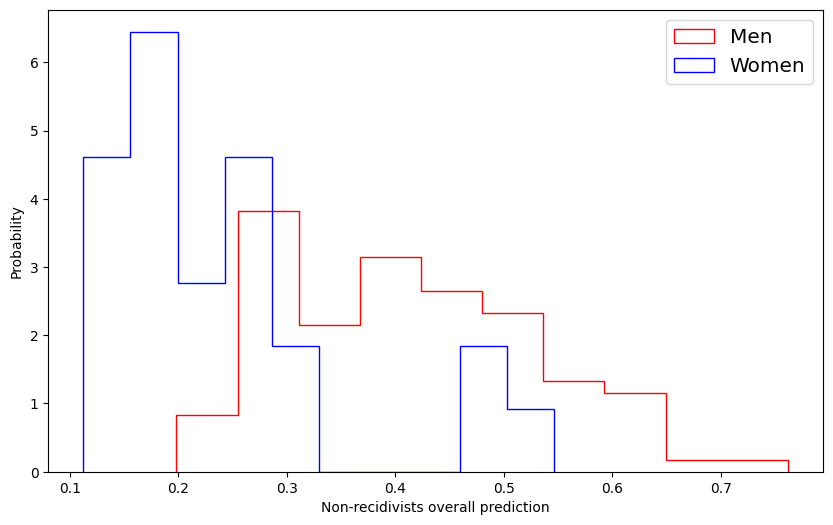

In [877]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [878]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.32
Average predicted probability of foreigner non-recidivist: 0.49


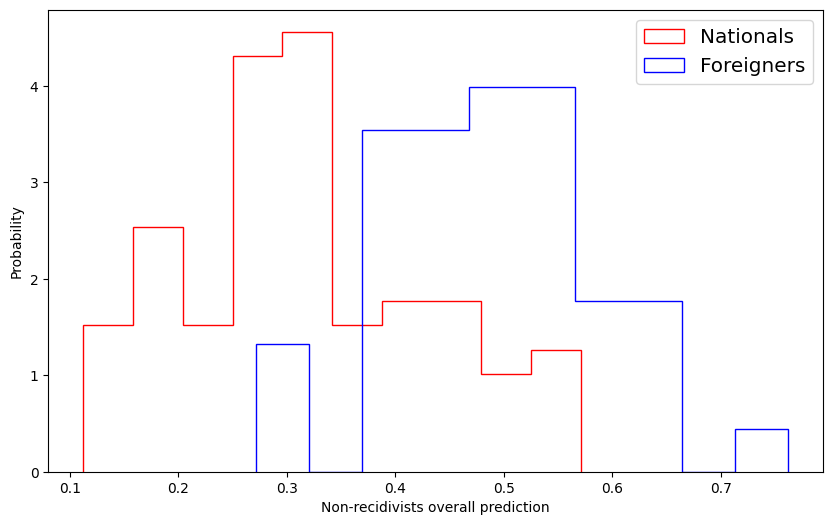

In [879]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



# Exercise 1

<b>1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model.</b>

For this task we set up a model cross-validation grid search training with a pipeline of the following models:

- MLP: Multi-Layer Perceptron, a Neural Network classification model.
- RF: Random Forest
- GB: Gradient Boosting classifier
- SVM: Support-Vector Machine classifier
- DTC: Decision Tree Classifier
- SGD: Stochastic Gradient Descent
- SVC: Support Vector Classification

Each of the predefined models at first used a StandardScaler(), but the results were not good. In this direction, we attempted to eventually use a RobustScaler() for scaling the input features values.

In [779]:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing  import StandardScaler, RobustScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle
import time
import random

In [780]:
################################################################################################
#################################            PIPELINE          #################################
################################################################################################

pipelines = {
    'MLP': make_pipeline(RobustScaler(), MLPClassifier(max_iter=500,random_state=1997,
                                                                       early_stopping=True,n_iter_no_change=5)),
    'AB': make_pipeline(RobustScaler(), AdaBoostClassifier(random_state=1997)),
    'RF': make_pipeline(RobustScaler(),RandomForestClassifier(random_state=1997)),
    'GB': make_pipeline(RobustScaler(),GradientBoostingClassifier(random_state=1997)),
    'SVM': make_pipeline(RobustScaler(), SVC(random_state=1997,probability=True)),
    'Tree': make_pipeline(RobustScaler(), DecisionTreeClassifier(random_state=1997)),
    'SGD': make_pipeline(RobustScaler(), SGDClassifier(random_state=1997)),
    'SVC': make_pipeline(RobustScaler(), SVC(random_state=1997,probability=True))
}


In [781]:
################################################################################################
#################################        HYPERPARAMETERS       #################################
################################################################################################

# MLP hyperparameters
MLP_hyperparameters = {
    'mlpclassifier__activation': ['relu','tanh',"logistic"],
    'mlpclassifier__solver':['adam',"lbfgs"],
    'mlpclassifier__hidden_layer_sizes': [(200,200,200,200,200,200),(150,150,150,150,150),(120,120,120,120,120)],
    'mlpclassifier__alpha': [0.0001,0.001]
}

# AdaBoost hyperparameters
AB_hyperparameters = [{
    "adaboostclassifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
    "adaboostclassifier__n_estimators": [200],
    "adaboostclassifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
}]



# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [50,100,200,250],
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__max_depth':[1,5,10],
    'randomforestclassifier__min_samples_leaf': [4,5,10],
    'randomforestclassifier__min_samples_split': [10,15,20],
    'randomforestclassifier__bootstrap': [True, False]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [1,2,50,100,200],
    'gradientboostingclassifier__learning_rate': [0.05,0.1,0.2],
    'gradientboostingclassifier__max_depth':[1.,3,5,20.,30.],
    'gradientboostingclassifier__min_samples_split':[0.1,0.5,1.],
    'gradientboostingclassifier__min_samples_leaf':[0.1,0.5],
    'gradientboostingclassifier__max_features':[1,10,40,100]
}

# SVM hyperparameters
svm_hyperparameters = {'svc__C': [0.1, 1, 10], 
          'svc__gamma': [1, 0.1, 0.01,"auto"],
          'svc__kernel': ['rbf']}

# Decision tree hyperparameters
tree_hyperparameters = {'decisiontreeclassifier__min_samples_leaf':[5,10,15,20],
                        'decisiontreeclassifier__max_features':[5,10,15],
                        'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                        'decisiontreeclassifier__max_depth':[2,4,6,8,10,12]}

# SGD hyperparameters
sgd_hyperparameters = {
    "sgdclassifier__loss": ["log", "modified_huber", "perceptron"],
    "sgdclassifier__penalty": ["l1", "l2", "elasticnet"],
    "sgdclassifier__alpha": [0.0001, 0.001, 0.01, 0.1],
    "sgdclassifier__max_iter": [1000],
    "sgdclassifier__tol": [1e-3],
    "sgdclassifier__random_state": [1997]
}



# SVC hyperparameters
svc_hyperparameters = { 
    "svc__kernel": ["linear", "rbf", "poly"],
    "svc__gamma": ["auto"],
    "svc__C": [0.1, 0.5, 1, 5, 10, 50, 100],
    "svc__degree": [1, 2, 3, 4, 5, 6]
}

# Create hyperparameters dictionary
hyperparameters = {'MLP': MLP_hyperparameters,
                   'AB': AB_hyperparameters,
                  'RF': rf_hyperparameters,
                  'GB': gb_hyperparameters,
                  'SVM':svm_hyperparameters,
                  'Tree':tree_hyperparameters,
                  'SGD':sgd_hyperparameters,
                  'SVC':svc_hyperparameters}

In [357]:
################################################################################################
#################################             FITTING          #################################
################################################################################################

def fit(pipelines,hyperparameters,train_X,train_y):
# Create empty dictionary called fitted_models
    fitted_models = {}
    start_time = time.time()

    # Loop through model pipelines, tuning each one and saving it to fitted_models
    for name, pipeline in pipelines.items():
        # Create cross-validation object from pipeline and hyperparameters
        model = GridSearchCV(pipeline, hyperparameters[name], cv=3, n_jobs=-1, scoring='roc_auc')

        # Fit model on X_train, y_train
        model.fit(train_X, train_y)

        # Store model in fitted_models[name] 
        fitted_models[name] = model

        # Print '{name} has been fitted'
        print('\n{0} has been fitted'.format(name))
        print("\tBest model param:",model.best_params_)

    print("\nTime:" + str((time.time() - start_time)/60))
    
    return fitted_models

fitted_models = fit(pipelines,hyperparameters,train_X,train_y)


MLP has been fitted
	Best model param: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (150, 150, 150, 150, 150), 'mlpclassifier__solver': 'lbfgs'}

AB has been fitted
	Best model param: {'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=3), 'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__n_estimators': 200}


/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



RF has been fitted
	Best model param: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200}


/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3240 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 668, in fit
    n_stages = self._fit_stages(
  File "/opt/homebrew/lib/


GB has been fitted
	Best model param: {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__max_features': 40, 'gradientboostingclassifier__min_samples_leaf': 0.1, 'gradientboostingclassifier__min_samples_split': 0.1, 'gradientboostingclassifier__n_estimators': 50}

SVM has been fitted
	Best model param: {'svc__C': 0.1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

Tree has been fitted
	Best model param: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__max_features': 10, 'decisiontreeclassifier__min_samples_leaf': 10}


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/sit


SGD has been fitted
	Best model param: {'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'log', 'sgdclassifier__max_iter': 1000, 'sgdclassifier__penalty': 'elasticnet', 'sgdclassifier__random_state': 1997, 'sgdclassifier__tol': 0.001}

SVC has been fitted
	Best model param: {'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}

Time:1.1171064853668213


For each one of them I print the final Mean cross-validated score of the best_estimator.

In [130]:
################################################################################################
#################################     SCORES FOR EACH MODEL    #################################
################################################################################################

for name,model in fitted_models.items():
    print(name, "Score: ", model.best_score_)

MLP Score:  0.6735623211033047
AB Score:  0.6800676554774916
RF Score:  0.6720010408534999
GB Score:  0.6779859484777516
SVM Score:  0.6895654436638043
Tree Score:  0.6298139474368982
SGD Score:  0.6795472287275565
SVC Score:  0.6893702836325787


Here we have the real deal: A plot of the test predict of the ROC Curve and its AUC Score.

=== MLP ===


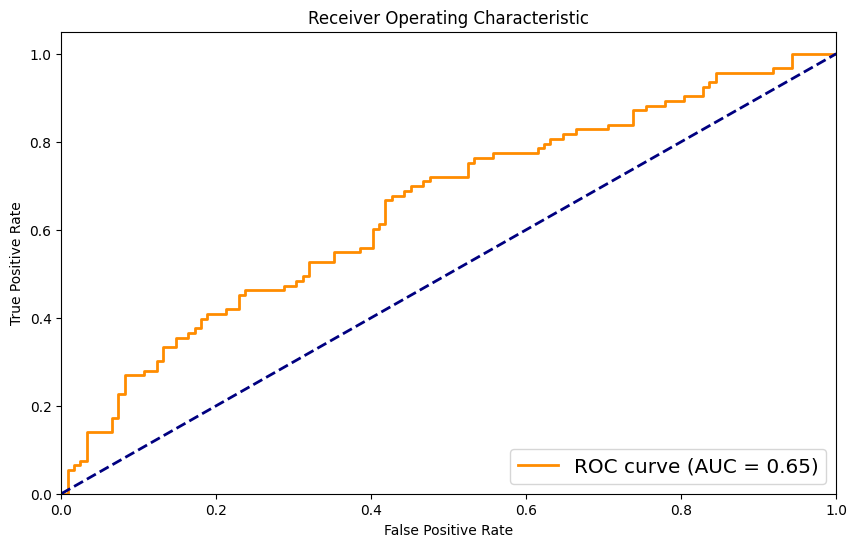

=== AB ===


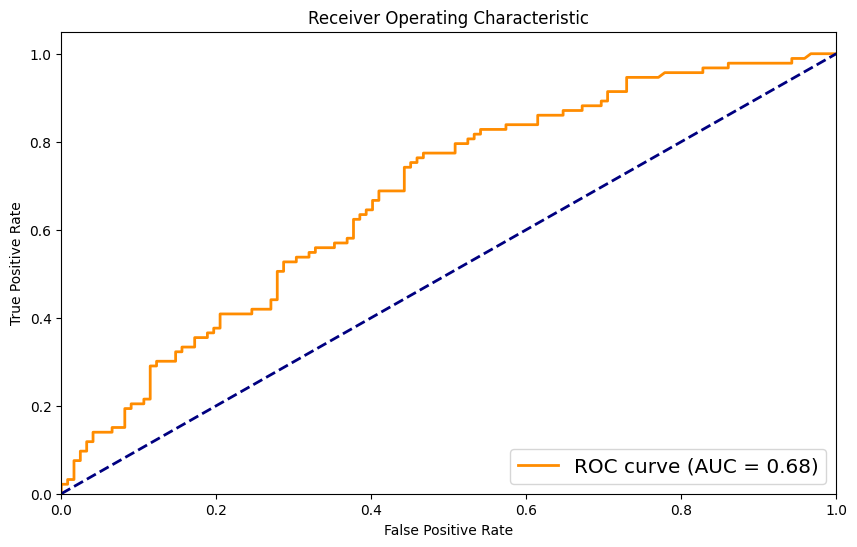

=== RF ===


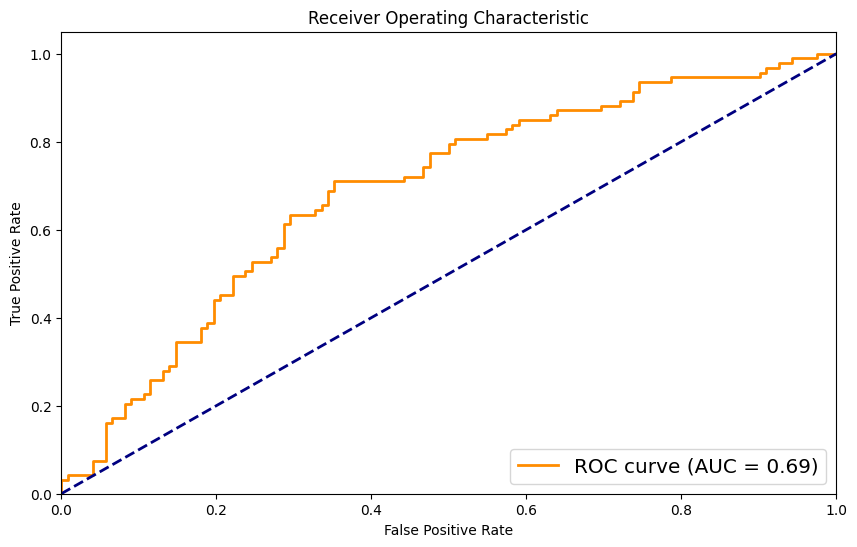

=== GB ===


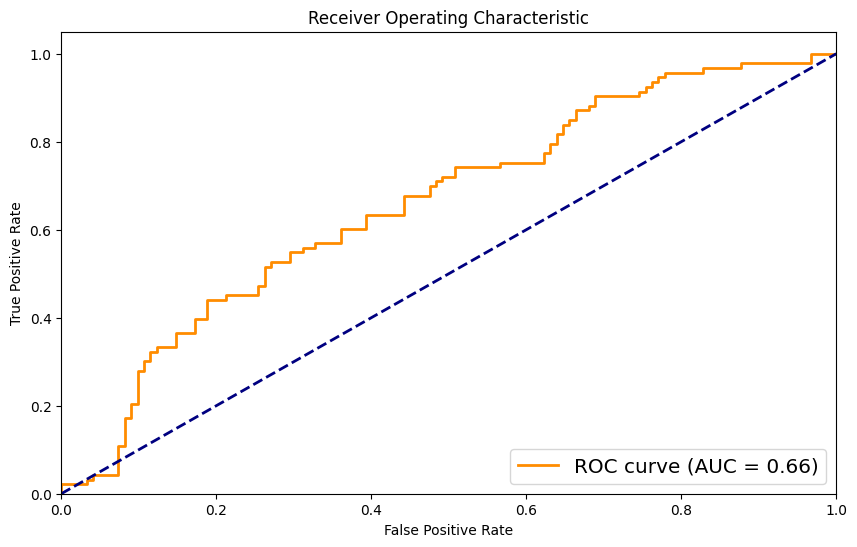

=== SVM ===


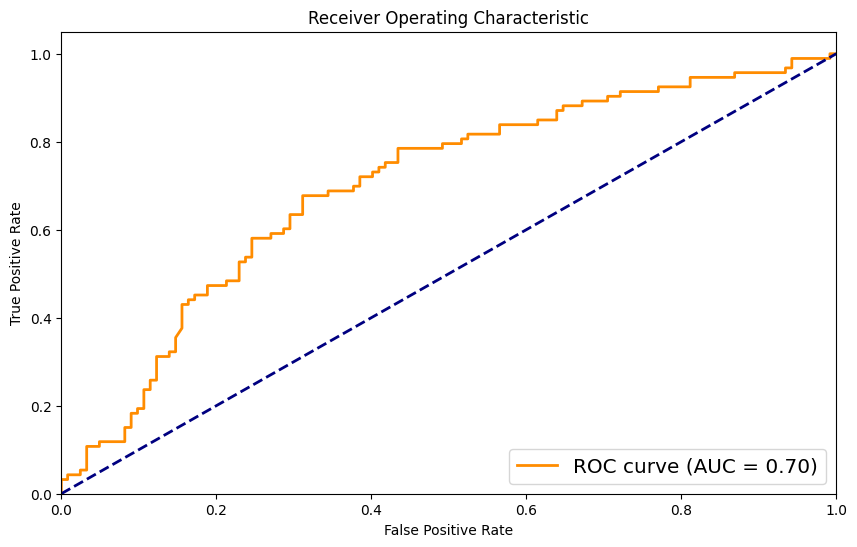

=== Tree ===


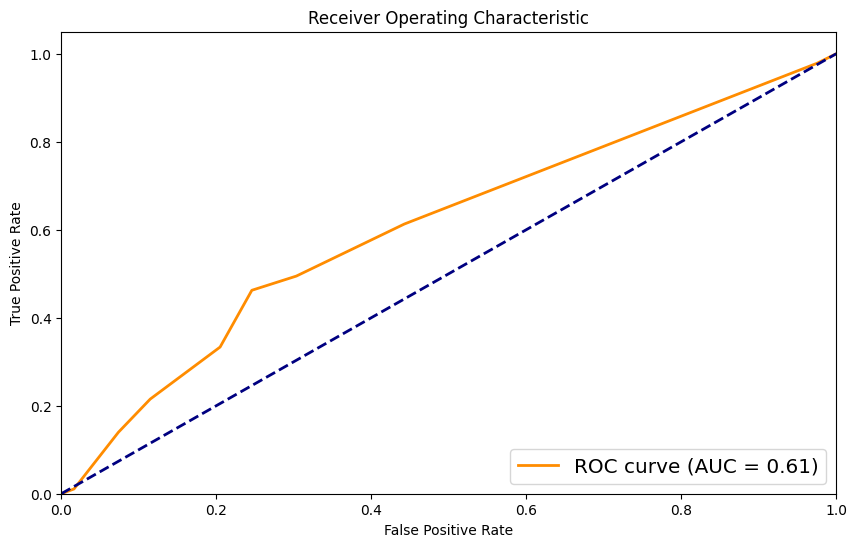

=== SGD ===


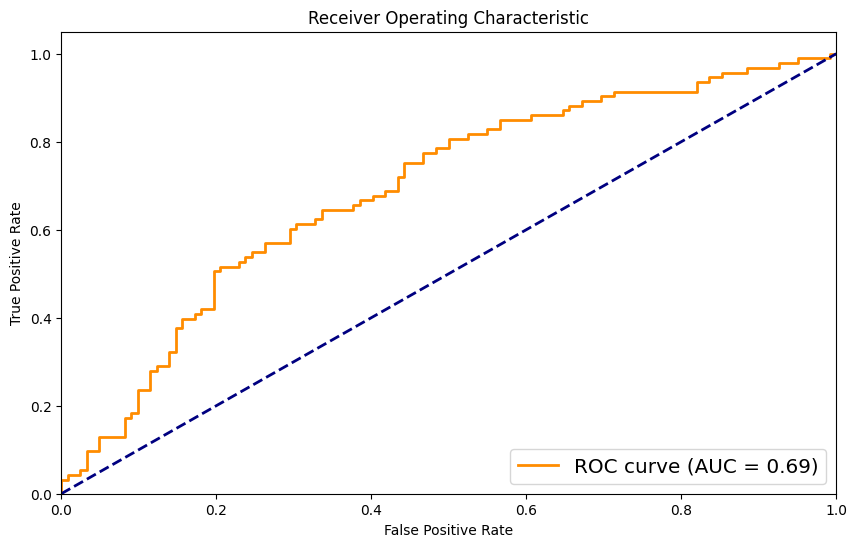

=== SVC ===


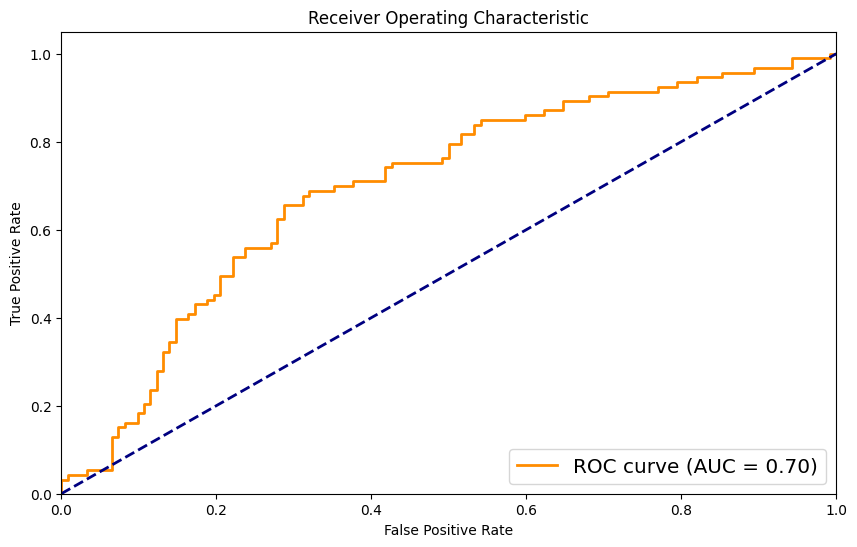

In [131]:
# print test scores
for name, model in fitted_models.items():
    print("===", name, "===")
    predALL_y = model.predict_proba(test_X)[:,1]
    _ = draw_roc_curve(test_y, predALL_y)

Saving the two machine learning models that gave us the better results(SVM and SVC) into binary files using the Python pickle module. The AUC score that each model gave us is:
- SVM: 0.70
- Random Forest: 0.70


The models are saved in the files 'SVM.pkl' and 'SVC.pkl', respectively.

The first model is a Support Vector Machine (SVM) model, and the second model is a Support Vector Classifier (SVC) model. Both models were fitted and tuned using a training dataset, and the best performing model was selected using cross-validation.

In the following cell we are also able to see the best configuration for the SVM and SVC models, which are the best models.

In [148]:
fitted_models["SVM"].best_params_

{'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

In [149]:
fitted_models["SVC"].best_params_

{'svc__C': 1, 'svc__degree': 1, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}

In [150]:
with open('SVM.pkl', 'wb') as f:
    pickle.dump(fitted_models["SVM"].best_estimator_, f)
    
with open('SVC.pkl', 'wb') as f:
    pickle.dump(fitted_models["SVC"].best_estimator_, f)

<b>2. Check if they satisfy the proposed fairness criteria.</b>

To evaluate the fairness of my models, in the following code we take each model and generate predictions of the probability of recidivism for the test set. Then, I computed the mean of these probabilities, stratified by the target columns of Gender and Nationality. I stored these results in a dataframe, which also includes two additional columns: the difference between the mean probabilities of the target columns. This information helped me to analyze the fairness of the models more thoroughly.

In [151]:
################################################################################################
#################################      FAIRNESS CRITERIA       #################################
################################################################################################

names = []
avgMan = []
avgWom = []
avgNat = []
avgFor = []
for name, model in fitted_models.items():
    names.append(name)
    predALL_y = model.predict_proba(test_X)[:,1]
    predPH_men_non_recidivists = predALL_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
    predPH_women_non_recidivists = predALL_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

    avgMan.append(predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists))

    avgWom.append(predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists))
    
    predPH_nationals_non_recidivists = predALL_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_foreigners_non_recidivists = predALL_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]
    
    avgNat.append(predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists))

    avgFor.append(predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists))
    
modelFair =  pd.DataFrame(list(zip(names,avgMan,avgWom,avgNat,avgFor)),columns=["Model Name",
                                                                               "Avg. Prob. Man",
                                                                                "Avg. Prob. Woman",
                                                                               "Avg. Prob. National",
                                                                               "Avg. Prob. Foreigner"])

modelFair["Diff Sex"] = abs(modelFair["Avg. Prob. Man"]-modelFair["Avg. Prob. Woman"])
modelFair["Diff Origen"] = abs(modelFair["Avg. Prob. National"]-modelFair["Avg. Prob. Foreigner"])

In [152]:
modelFair.sort_values("Diff Sex",ascending=True)

,Model Name,Avg. Prob. Man,Avg. Prob. Woman,Avg. Prob. National,Avg. Prob. Foreigner,Diff Sex,Diff Origen
1,AB,0.488691,0.459515,0.478566,0.490455,0.029176,0.011889
2,RF,0.384377,0.304781,0.344816,0.409620,0.079596,0.064804
5,Tree,0.394443,0.302026,0.353770,0.414750,0.092417,0.060981
4,SVM,0.392487,0.275785,0.341097,0.418180,0.116702,0.077083
7,SVC,0.398304,0.273620,0.342136,0.427916,0.124684,0.085780
3,GB,0.396189,0.270777,0.336543,0.431365,0.125412,0.094823
6,SGD,0.400541,0.264509,0.339894,0.431765,0.136032,0.091871
0,MLP,0.377421,0.041670,0.293416,0.342096,0.335751,0.048681


Based on the table, the two best models in terms of fairness are AdaBoost (<b>AB</b>) and Random Forest (<b>RF</b>).

AdaBoost has the smallest difference between the mean probabilities of the target columns (0.029176 for gender and 0.011889 for nationality), which indicates that it is able to make predictions that are relatively fair with respect to these variables. It is also worth noting that AdaBoost has the highest overall mean probability of recidivism (0.481830), which suggests that it may be better at identifying individuals who are likely to reoffend.

Random Forest, on the other hand, has a larger difference between the mean probabilities of the target columns than AdaBoost (0.079596 for gender and 0.064804 for nationality), but still performs relatively well in terms of fairness compared to the other models in the table. It also has the lowest overall mean probability of recidivism (0.361869), which could be beneficial in contexts where reducing false positives is particularly important. RF is a good model taking in consideration Accuracy and Fairness.

Overall, both AdaBoost and Random Forest seem to strike a good balance between predictive performance and fairness, making them the two best models in this context.

Therefore, from now on, I'll work with this two models and i will also use SVM model. Overall, the Support Vector Machine (<b>SVM</b>)  model appears to perform reasonably well on the task, with the lowest Diff Sex value (0.116702	) compared to other models. This suggests that the model is able to make accurate predictions while maintaining some degree of fairness between genders. However, it's important to note that there is still room for improvement, particularly with respect to the Diff Origen metric (0.077083), which suggests some degree of disparity in predictions based on nationality. To conclude, we will continue using the 3 following models:

- <b>AB</b>
- <b>RF</b>
- <b>SVM</b>


In [157]:
################################################################################################
#################################      METHODS SELECTION       #################################
################################################################################################

AB = fitted_models["AB"].best_estimator_
RF = fitted_models["RF"].best_estimator_
#Tree = fitted_models["Tree"].best_estimator_
SVM = fitted_models["SVM"].best_estimator_
#SVC = fitted_models["SVC"].best_estimator_
#GB = fitted_models["GB"].best_estimator_
#SGD = fitted_models["SGD"].best_estimator_
#MLP = fitted_models["MLP"].best_estimator_


models = {"AB":AB, "SVM":SVM, "RF":RF}#, "SVC":SVC ,"Tree": Tree, "GB": GB, "SGD": SGD, "MLP": MLP}

<b>3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity.</b>

In [166]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from IPython.display import display, HTML

for name, model in models.items():
    
    predALL_y = model.predict_proba(test_X)[:,1]
    matrix = pd.DataFrame(confusion_matrix([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y)),columns=["Actual Positive","Actual Negative"])
    matrix.index = ["Predicted Positive","Predicted Negative"]
    f1 = f1_score([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y),average="macro")
    print("\nMODEL:",name)
    print("\tConfusion Matrix")
    display(HTML(matrix.to_html()))
    print("\tF1-Score:",f1)


MODEL: AB
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,98,24
Predicted Negative,59,34


	F1-Score: 0.5764200432006455

MODEL: SVM
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,104,18
Predicted Negative,60,33


	F1-Score: 0.5928030303030303

MODEL: RF
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,100,22
Predicted Negative,59,34


	F1-Score: 0.5840598055840838


### MODEL: AB

- True Positives (TP): 98
- True Negatives (TN): 34
- False Positives (FP): 24
- False Negatives (FN): 59
<br>
<br>F1-Score: 0.576

The AB model has a relatively low F1 score compared to SVM and RF models. This is mainly due to a high number of false negatives (59), which means the model has difficulty predicting positive cases (recidivism). However, the model has a high number of true positives (98), which shows that the model has some ability to correctly identify positive cases.

### MODEL: SVM

- True Positives (TP): 104
- True Negatives (TN): 33
- False Positives (FP): 18
- False Negatives (FN): 60
<br>
<br>
F1-Score: 0.593

The SVM model has a slightly higher F1 score compared to AB and RF models. This is due to a relatively balanced number of true positives and false negatives. However, the model has a higher number of false positives (18) compared to AB and RF models, which means it is less specific in predicting negative cases.

### MODEL: RF

- True Positives (TP): 100
- True Negatives (TN): 34
- False Positives (FP): 22
- False Negatives (FN): 59
<br>
<br>
F1-Score: 0.584

The RF model has a lower F1 score compared to SVM but higher compared to AB. This is due to a high number of false negatives (59), which is similar to the AB model. However, the model has a slightly higher number of true positives (100) compared to AB, which shows a better ability to identify positive cases. The number of false positives (22) is also higher than AB, which indicates lower specificity.

Let's consider now the fairness implications of these models with respect to protected variables such as Gender and Nationality.

## Gender

In [167]:
################################################################################################
#################################             GENDER           #################################
################################################################################################

def build_confusion_matrix(test_X,test_y,preds):
    resultDF = pd.DataFrame()
    resultDF["Gender"] = ["Male" if i == 1 else "Female" for i in test_X["V1_sexe_Home"]]
    resultDF["Nationality"] = ["National" if i == 1 else "Foreigner" for i in test_X["V2_estranger_Espanyol"]]
    resultDF["True"] = ["Si" if i == "Sí" else "No" for i in test_y]
    resultDF["Predict"] = ["Si" if i == 1 else "No" for i in np.round(preds)]
    return resultDF

for name, model in models.items():
    print("MODEL:",name)
    df = build_confusion_matrix(test_X,test_y,model.predict_proba(test_X)[:,1])
    pt = df.pivot_table(index=["Predict"], columns=["Gender","True"], aggfunc='size',fill_value=0)
    display(HTML(pt.to_html()))
print("Amount of people by gender:\n",df["Gender"].value_counts())

MODEL: AB


MODEL: SVM


MODEL: RF


Amount of people by gender:
 Male      183
Female     32
Name: Gender, dtype: int64


### MODEL: AB

For the AB model, the percentage of misclassified cases for females is 10% (8 out of 32), meaning that 90% were correctly classified. For males, the percentage of misclassified cases is 14% (51 out of 125), indicating that 86% were correctly classified. Therefore, the misclassification rates are similar for both groups.

Regarding correct classification, 76.6% of females were classified correctly, regardless of whether they were recidivists or not, while 64.32% of males were classified correctly. Thus, the AB model's performance is slightly better for females than for males.

### MODEL: SVM

For the SVM model, the percentage of misclassified cases for females is 3.12% (1 out of 32), meaning that 96.88% were correctly classified. For males, the percentage of misclassified cases is 27.32% (50 out of 183), indicating that 72.68% were correctly classified. Thus, the misclassification rates are significantly higher for males than for females.

Regarding correct classification, 94.87% of females were classified correctly, regardless of whether they were recidivists or not, while 72.68% of males were classified correctly. Thus, the SVM model's performance is significantly better for females than for males.

### MODEL: RF

For the RF model, the percentage of misclassified cases for females is 23.33% (7 out of 30), meaning that 76.67% were correctly classified. For males, the percentage of misclassified cases is 28.77% (54 out of 188), indicating that 71.23% were correctly classified. Therefore, the RF model has a higher misclassification rate for males than for females.

Regarding correct classification, 76.67% of females were classified correctly, regardless of whether they were recidivists or not, while 71.56% of males were classified correctly. Thus, the RF model's performance is slightly better for females than for males in terms of correct classification.

## Nationality

In [168]:
################################################################################################
#################################          NATIONALITY         #################################
################################################################################################

for name, model in models.items():
    print("MODEL:",name)
    df = build_confusion_matrix(test_X,test_y,model.predict_proba(test_X)[:,1])
    pt = df.pivot_table(index=["Predict"], columns=["Nationality","True"], aggfunc='size',fill_value=0)
    display(HTML(pt.to_html()))
print("Amount of people by Nationality:\n",df["Nationality"].value_counts())

MODEL: AB


MODEL: SVM


MODEL: RF


Amount of people by Nationality:
 National     126
Foreigner     89
Name: Nationality, dtype: int64


### MODEL: AB

For the AB model, the percentage of misclassified cases for foreigners is 39.33% (35 out of 89), while for nationals it is 38.10% (48 out of 126). This indicates a higher rate of misclassification for foreigners, which could suggest a possible presence of discrimination in the model.

Regarding correct classification, the percentage of correctly classified cases for foreigners in the AB model is 60.67% (54 out of 89). For nationals, it would be 78 out of 126 correctly classified, which gives a percentage of 61.9% correct classification.

The fact that the percentage of misclassified cases for foreigners is higher than that for nationals suggests that the AB model may not be performing as well for foreigners as it is for nationals. Additionally, the lower percentage of correct classification for foreigners compared to nationals also suggests that the model's performance may be biased against foreigners. The differcences are not very big though.

### MODEL: SVM

The percentage of misclassified cases for foreigners is 39.33% (35 out of 89) and for nationals it is 34.13% (43 out of 126). This indicates a higher rate of misclassification for foreigners compared to nationals, suggesting the possibility of discrimination against foreign individuals in the model.

In terms of correct classification, the SVM model correctly classified 60.67% (54 out of 89) of foreign individuals and 83 out of 126 (65.87%) national individuals. Overall, the model's performance seems to be better for national individuals, as they have a higher percentage of correct classification compared to foreign individuals.

### MODEL: RF

For the RF model, the percentage of misclassified cases for foreigners is 38.2% (34 out of 89), while for nationals it is 37.30% (47 out of 126). This suggests that is almost the same for foreigners.

Regarding correct classification, the percentage of correctly classified cases for foreigners in the AB model is 61.8%  (55 out of 89). For nationals, it would be 79 out of 126 correctly classified, which gives a percentage of 62.7% correct classification.

It seems that the RF model performs similarly for both foreigners and nationals, with only a slight difference in the percentage of misclassified cases.

## Questions (justify your answers)

<b>1. Is there a method that can achieve better predictive power than human experts?</b>

At present, it's difficult to create a machine learning model that can replicate the decision-making ability of a human expert in this field because we lack the computational power to store all the expert's knowledge and understand it in the same way. However, we can enhance decision-making by combining machine learning techniques with the knowledge of human experts.

In terms of accuracy, it's challenging to compare the performance of human experts and machine learning models in this case because the expert's predictions were given in three classes, and the most frequently occurring class was "unsure" or "moderate". Additionally, the world is biased, and the data used to train the model may reflect that bias, which means the model could learn and replicate the same biases.

#### 2. Is this method better than human experts in terms of fairness?

When comparing the fairness of the models to human experts in recidivism prediction, it can be seen that the error rates of the models are higher than those of human experts. Therefore, the answer to whether the method is better than human experts in terms of fairness is no.

Although some models have shown less bias than the expert in certain areas, it should be noted that human bias is generally low and evenly distributed across risk classifications. However, fairness metrics used to evaluate the models are still based on the accuracy of predictions, and the issues faced in the first question still apply.

It is also important to acknowledge that there is a possibility of encountering biased human "experts" in the future.

#### 3. Which is the most suited fairness criterium for this problem? Why?

The following criteria are the features or variables in the input data that the AdaBoost classifier (fitted model) considers to be the most important in making its predictions. The list shows the top 10 features in order of importance, based on their corresponding feature importances.

In [191]:
AB_criteriums = list(zip(fitted_models['AB'].best_estimator_.named_steps['adaboostclassifier'].feature_importances_,train_X))

In [192]:
AB_criteriums.sort(reverse=True)
for i in range(10):
    print(AB_criteriums[i])

(0.125, 'V8_edat_fet')
(0.125, 'V20_nombre_antecedents')
(0.08, 'V75_@11_delinquencia_grup_iguals_Baix')
(0.065, 'V74_@10_baix_rendiment_escola_Alt')
(0.065, 'V1_sexe_Dona')
(0.055, 'V78_@14_escassa_habilitat_pares_educar_Moderat')
(0.045, 'V86_@22_problemes_concentracio_hiperactivitat_Baix')
(0.045, 'V1_sexe_Home')
(0.045, 'V15_fet_agrupat_Altres')
(0.04, 'V81_@17_actitud_negatives_Alt')


For example, V8_edat_fet refers to a variable in the SAVRY dataset related to the age of the offender at the time of the offense.

V20_nombre_antecedents' is a variable in the SAVRY dataset that represents the number of prior offenses or convictions that the young offender has. The variable is a count variable and ranges from 0 to 19 or more. It is one of the risk factors that the SAVRY tool uses to assess the risk of future violent behavior in young offenders. A higher number of prior offenses or convictions would indicate a greater risk of reoffending. etc ..

One of the most important factors for Machine Learning models to make predictions regarding recidivism are the number of past records, the age, social implications, and the neighborhood of the individual etc. 

However, these criteria may not guarantee fairness because there could be other important features that only a small group of individuals possess. These features may not be considered significant by the model, which could lead to unfairness. To ensure fairness, the Equalized Odds criterion seems to be the most appropriate. This criterion guarantees that both protected groups have the same odds of being targeted. Achieving this criterion is crucial even though it's challenging. In terms of criminalism in Catalonia, it's essential to achieve high accuracy among all groups. In the US context, Demographic Parity may be more suitable. However, crime is often misconstrued as a racial issue, when it's actually a classist issue that originated from historic racial discrimination against minority groups. Therefore, it's crucial to address this problem and eliminate this legacy.



#### 4. What are your conclusion about the use of a ML model to predict recividism?

Based on the analysis performed in this notebook, it can be concluded that the use of ML models for recidivism prediction can be helpful, but should not be the sole basis for decision making. It is essential to combine the predictions of these models with expert opinions from professionals in the field. It is important to note that machine learning models can reflect the biases present in society, and their decisions can be influenced by the quality and quantity of the data they are trained on. Therefore, it is crucial to ensure that these models are fair and unbiased, and their predictions are thoroughly scrutinized before making decisions based on them. Ultimately, human judgment should always be present in the decision-making process, and the use of ML models should be seen as a complementary tool, rather than a replacement for human expertise.

# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

In machine learning, it is important to ensure that the predictions made by the model are fair and unbiased. One of the key sources of bias is the presence of protected features such as sex, nationality, race, etc., which can result in disparities in the model's predictions across different groups. EBR is a mitigation method that addresses this issue by ensuring that the base rates (i.e., the proportion of positive and negative outcomes) are equal across different groups with respect to the protected feature.

The EBR method involves a stratified oversampling procedure, which is applied to the training data. The protected feature is divided into I possible values, corresponding to different groups, with one group being designated as the reference group. For each group i, different from the reference group, we compute the number of positive or negative condition samples |Si| that need to be added to the training data, where |Si| is the absolute value of Si = P(x(f')=gi)(P(y|x(f')=gi) - P(y|x(f')=gref)), with P(y|x(f')=gi) and P(y|x(f')=gref) being the probabilities of a positive outcome given the feature value gi and the reference group feature value, respectively.

If Si is negative, then we add |Si| negative condition samples of group gi to the data, with the outcome variable set to 0. If Si is positive, then we add |Si| positive condition samples of group gi to the data, with the outcome variable set to 1. This procedure ensures that the base rates are equal across all groups with respect to the protected feature. Specifically, the probability of the protected feature being gi in any group i will be equal to the probability of the protected feature being gref in the reference group.

By using EBR to mitigate bias, we can analyze the influence of data bias with respect to protected features on group fairness and the predictive performance of the model. This can help us gain insights into the role that these conditions play in determining group fairness and the importance of different features for prediction.

Let's try now to write some code and implement tn python EBR method for our case.

In [563]:
################################################################################################
#################################          EBR METHOD          #################################
################################################################################################

#Creating new train and test sets
train_X_ebr = train_X.copy()
train_X_ebr["Target"] = train_y

train_X_ebr.groupby("V1_sexe_Dona")[["Target"]].size()

V1_sexe_Dona
0    379
1     56
dtype: int64

We can see above how imbalance is our dataset regarding <b>the gender</b>, due to the fact that we have a difference of 381-54 = 327 individuals between men and women. Now we are going to try to have the equal number of men and women. We will do that by producing more rows for the minority, by replicating rows.

In [564]:
idxs = train_X_ebr[train_X_ebr.V1_sexe_Dona == 1].index
rows = np.random.choice(idxs, 379-56)
train_X_ebr = pd.concat([train_X_ebr,train_X_ebr.loc[rows]])

train_X_ebr.groupby("V1_sexe_Dona")[["Target"]].size()

V1_sexe_Dona
0    379
1    379
dtype: int64

We are going to apply the same technique regarding <b>the nationality</b>. We can see that also for the nationality we have a difference of 486-276=210

In [565]:
train_X_ebr.groupby("V2_estranger_Estranger")[["Target"]].size()

V2_estranger_Estranger
0    523
1    235
dtype: int64

In [566]:
idxs = train_X_ebr[train_X_ebr.V2_estranger_Estranger == 1].index
rows = np.random.choice(idxs, 523-235)
train_X_ebr = pd.concat([train_X_ebr,train_X_ebr.loc[rows]])

Now that we have the same sizes we can split again train and test datasets and fit again our the three models that we have worked with:
- AB
- SVM
- RF

In [569]:
################################################################################################
#################################      TRAIN-TEST SPLIT        #################################
################################################################################################

train_y_ebr = train_X_ebr["Target"].values
train_X_ebr = train_X_ebr.drop(["Target"],axis=1)
print(train_X_ebr.shape, train_y_ebr.shape)

(1513, 96) (1513,)


In [570]:
################################################################################################
#################################        EBR PIPELINES         #################################
################################################################################################

pipelines_ebr = {}
pipelines_ebr["AB"] = pipelines["AB"]
pipelines_ebr["SVM"] = pipelines["SVM"]
pipelines_ebr["RF"] = pipelines["RF"]
fitted_models_ebr = fit(pipelines_ebr,hyperparameters,train_X_ebr,train_y_ebr)


AB has been fitted
	Best model param: {'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=5), 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 200}

SVM has been fitted
	Best model param: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



RF has been fitted
	Best model param: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 250}

Time:0.49475330114364624


In [571]:
# Display best_score_ for each fitted model
for name,model in fitted_models_ebr.items():
    print(name, "Score: ", model.best_score_)

AB Score:  0.9701466172054407
SVM Score:  0.9699863214268977
RF Score:  0.9612054603051


=== AB ===


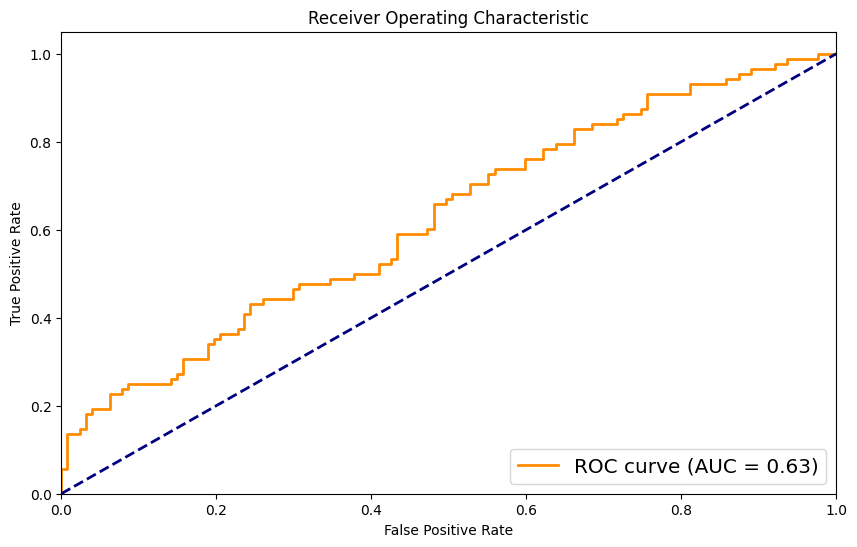

=== SVM ===


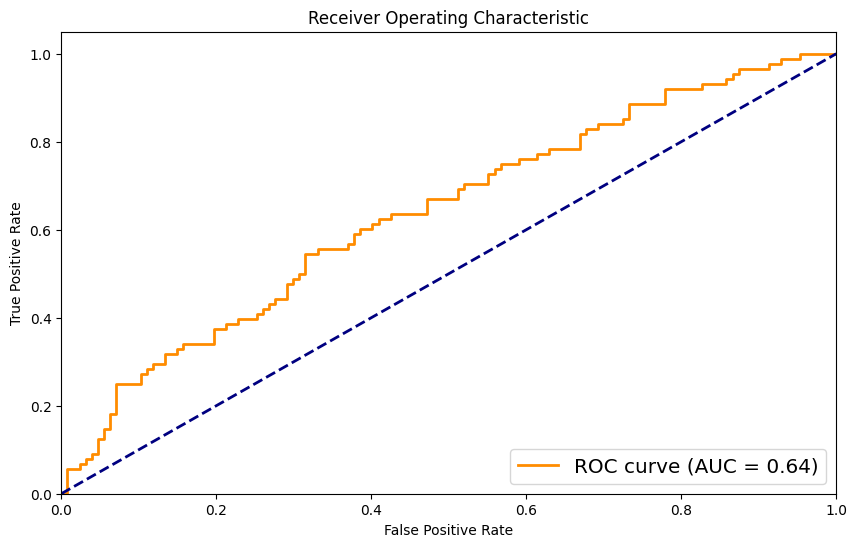

=== RF ===


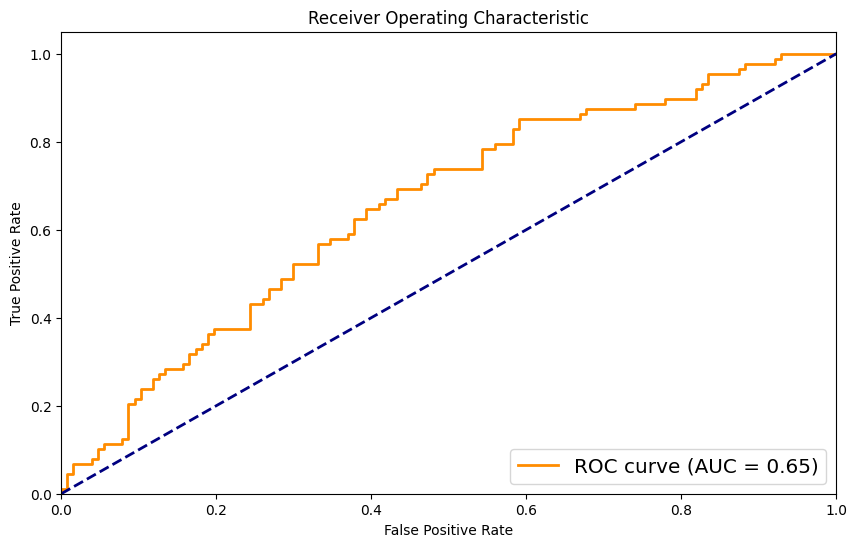

In [574]:
# print test scores
for name, model in fitted_models_ebr.items():
    print("===", name, "===")
    predALL_y = model.predict_proba(test_X)[:,1]
    _ = draw_roc_curve(test_y, predALL_y)

In [573]:
for name, model in fitted_models_ebr.items():
    
    predALL_y = model.predict_proba(test_X)[:,1]
    matrix = pd.DataFrame(confusion_matrix([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y)),columns=["Actual Positive","Actual Negative"])
    matrix.index = ["Predicted Positive","Predicted Negative"]
    f1 = f1_score([1 if i == "Sí" else 0 for i in test_y], np.round(predALL_y),average="macro")
    print("\nMODEL:",name)
    print("\tConfusion Matrix")
    display(HTML(matrix.to_html()))
    print("\tF1-Score:",f1)


MODEL: AB
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,83,44
Predicted Negative,46,42


	F1-Score: 0.5655980603448276

MODEL: SVM
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,89,38
Predicted Negative,45,43


	F1-Score: 0.5954340384048606

MODEL: RF
	Confusion Matrix


,Actual Positive,Actual Negative
Predicted Positive,94,33
Predicted Negative,49,39


	F1-Score: 0.591898148148148


#### <u>Comments</u>

We can observe that the results that we have gotten after applying EBR method are not better than before. Furthermore, the AUC scores seem to be worse than before. For example, for the AB method from 0.68 that we have before the score decreased to 0.63.

Regarding the confusion matrices, we can see on the following picture the confusion matrices that we have before in order to compare them:

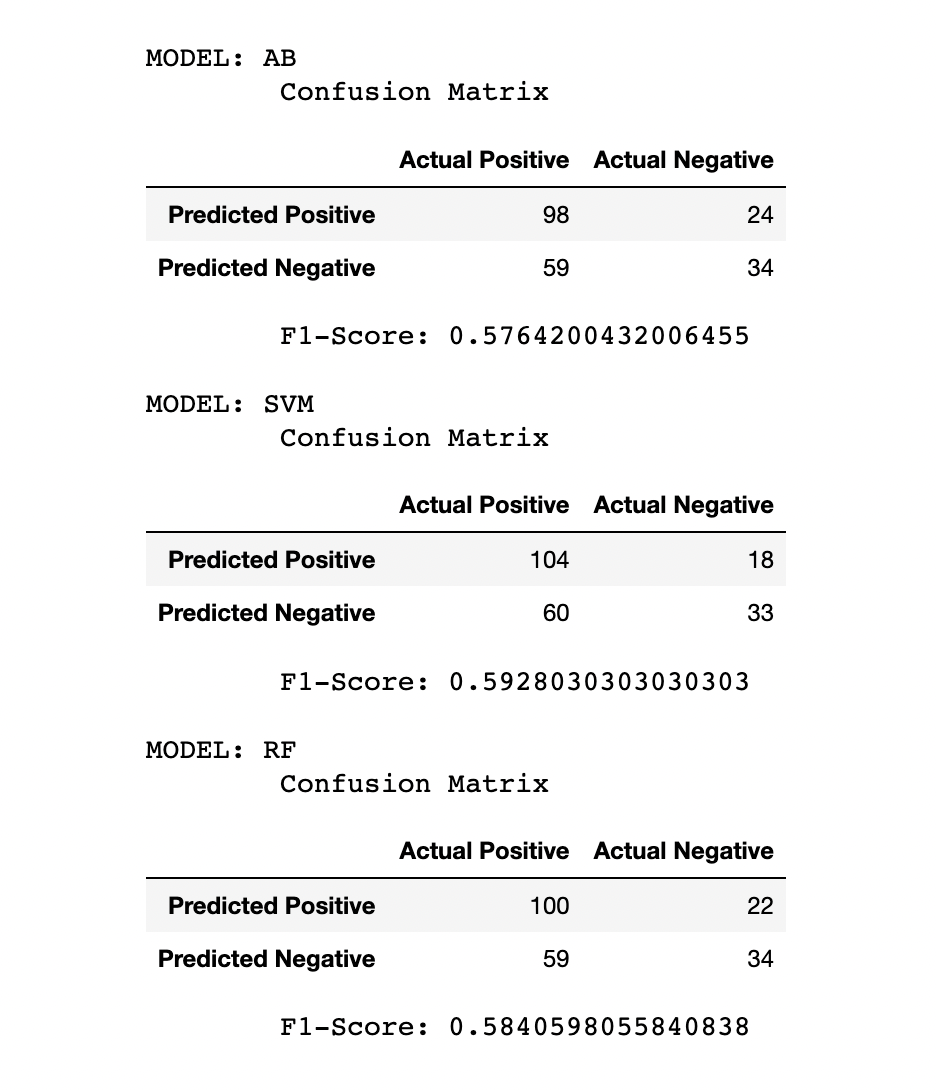

We observe that the f1 scores except from RF method were better before applying the EBR method. For the RF method we can see a very small improvement.

So overall, EBR (Equalized Bayesian Reweighting) is a method that aims to mitigate algorithmic bias in classification models. However, the effectiveness of this method heavily depends on how the dataset is distributed. While EBR can reduce disparities in certain protected features, it may also induce disparities in other protected features. For instance, targeting EBR towards a certain religious group may cause disparities in gender or race.

It's worth noting that the success of EBR also depends on the representation of protected samples and input features in the dataset. In some cases, EBR can reduce disparities between groups, but it may struggle with other protected features. Additionally, when dealing with small subgroups, even minor changes in the input can lead to significant changes in the overall outcome.

In conclusion, while EBR can be a useful tool for mitigating algorithmic bias in certain cases, it is not a solution to unfair classification. We should take into consideration the characteristics of the dataset and the protected features when deciding whether to apply EBR or not.

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

At first, we have to underline the fact that ML explainability models have been applied to the BEST ML model previously, so will not implement again the iii). Now, we are going to apply ML explainability techniques also for:
- i) Human risk assessment score
- ii) SAVRY baseline model

## i) Human risk assessment score

We have seen that the column V56_@R1_resum_risc_global_reverse is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but applying his/her own judgment independently of the obtained score.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

In multi-label classification, each instance can belong to multiple classes simultaneously. In the case of the V56_@R1_resum_risc_global_reverse feature, it can have one of three possible labels: low risk, medium risk, or high risk.

To handle this multi-label classification problem, we can use the OneVsRestClassifier strategy. This strategy trains one binary classifier for each label, where each classifier is responsible for predicting whether an instance belongs to that label or not. In this way, we can transform a multi-label classification problem into multiple binary classification problems.

For example, in the case of the V56_@R1_resum_risc_global_reverse feature, we can use the OneVsRestClassifier to train three binary classifiers, one for each possible label (low risk, medium risk, and high risk). During prediction, each binary classifier will output a probability score indicating the likelihood of an instance belonging to that label. The final prediction will then be a combination of the output from all three binary classifiers.

Therefore, we will try to transform the train to a 3-multi-labelled problem. To train the binary classifiers, we can use a list of models that we have seen in Exercise 1, such as decision tree, random forest, GB, AB, SVM etc. The OneVsRestClassifier will create a separate instance of each model for each label and train it on the corresponding subset of the data.

In [951]:
###########################################################################################################
#################################      HUMAN RISK ASSESSMENT SCORE        #################################
###########################################################################################################

from sklearn.multiclass import OneVsRestClassifier

# Transform the categorical variable to numerical-labeled (0, 1 and 2)
train_y_hrisk = train["V56_@R1_resum_risc_global_reverse"].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)
test_y_hrisk = test["V56_@R1_resum_risc_global_reverse"].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)

# Transform the test sets with the binarization of this multi-labeled variable
pre_train_y = preprocessing.label_binarize(train_y_hrisk, classes=[0, 1, 2])
pre_test_y = preprocessing.label_binarize(test_y_hrisk, classes=[0, 1, 2])

# Pipeline dictionary using OneVsRestClassifier
pipelines_hrisk = {
    'MLP': make_pipeline(RobustScaler(), OneVsRestClassifier(MLPClassifier(max_iter=500,random_state=1997,
                                                                       early_stopping=True,n_iter_no_change=5))),
    'AB': make_pipeline(RobustScaler(), OneVsRestClassifier(AdaBoostClassifier(random_state=1997))),
    'RF': make_pipeline(RobustScaler(), OneVsRestClassifier(RandomForestClassifier(random_state=1997))),
    'GB': make_pipeline(RobustScaler(), OneVsRestClassifier(GradientBoostingClassifier(random_state=1997))),
    'SVM': make_pipeline(RobustScaler(), OneVsRestClassifier(SVC(random_state=1997,probability=True))),
    'Tree': make_pipeline(RobustScaler(), OneVsRestClassifier(DecisionTreeClassifier(random_state=1997))),
    'SGD': make_pipeline(RobustScaler(), OneVsRestClassifier(SGDClassifier(random_state=1997))),
    'SVC': make_pipeline(RobustScaler(), OneVsRestClassifier(SVC(random_state=1997,probability=True)))
}

In [952]:
################################################################################################
#################################        HYPERPARAMETERS       #################################
################################################################################################

# Hyperparameters for OneVsRestClassifier

# MLP hyperparameters
MLP_hyperparameters = {
    'onevsrestclassifier__estimator__activation': ['relu', 'tanh', 'logistic'],
    'onevsrestclassifier__estimator__solver': ['adam', 'lbfgs'],
    'onevsrestclassifier__estimator__hidden_layer_sizes': [(200,200,200,200,200,200),(150,150,150,150,150),(120,120,120,120,120)],
    'onevsrestclassifier__estimator__alpha': [0.0001, 0.001]
}

# AdaBoost hyperparameters
AB_hyperparameters = [{    
    "onevsrestclassifier__estimator__base_estimator": [DecisionTreeClassifier(max_depth=ii) for ii in range(1,6)],
    "onevsrestclassifier__estimator__n_estimators": [200],
    "onevsrestclassifier__estimator__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
}]



# Random Forest hyperparameters
rf_hyperparameters = {
    'onevsrestclassifier__estimator__n_estimators': [50,100,200,250],
    'onevsrestclassifier__estimator__max_features': ['auto'],
    'onevsrestclassifier__estimator__max_depth': [1,5,10],
    'onevsrestclassifier__estimator__min_samples_leaf': [4,5,10],
    'onevsrestclassifier__estimator__min_samples_split': [10,15,20],
    'onevsrestclassifier__estimator__bootstrap': [True, False]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'onevsrestclassifier__estimator__n_estimators': [1,2,50,100,200],
    'onevsrestclassifier__estimator__learning_rate': [0.05,0.1,0.2],
    'onevsrestclassifier__estimator__max_depth': [1.,3,5,20.,30.],
    'onevsrestclassifier__estimator__min_samples_leaf': [1,2,4],
    'onevsrestclassifier__estimator__min_samples_split': [2,5,10],
    'onevsrestclassifier__estimator__max_features': ['sqrt', 'log2', None]
}

# SVM hyperparameters
svm_hyperparameters = {
    'onevsrestclassifier__estimator__C': [0.1, 1, 10],
    'onevsrestclassifier__estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'onevsrestclassifier__estimator__degree': [2,3,4,5],
    'onevsrestclassifier__estimator__gamma': ['scale', 'auto']
}

# Decision tree hyperparameters
tree_hyperparameters = {
    'onevsrestclassifier__estimator__max_depth': [1,3,5,10,20,None],
    'onevsrestclassifier__estimator__min_samples_leaf': [1,2,4,8,12],
    'onevsrestclassifier__estimator__min_samples_split': [2,5,10,15],
    'onevsrestclassifier__estimator__criterion': ['gini', 'entropy']
}

# SGD hyperparameters
sgd_hyperparameters = {
    'onevsrestclassifier__estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'onevsrestclassifier__estimator__penalty': ['l2', 'l1', 'elasticnet'],
    'onevsrestclassifier__estimator__alpha': [0.0001, 0.001, 0.01],
    'onevsrestclassifier__estimator__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}



# SVC hyperparameters
svc_hyperparameters = {
    'onevsrestclassifier__estimator__C': [0.1, 1, 10],
    'onevsrestclassifier__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'onevsrestclassifier__estimator__gamma': ['scale', 'auto']
}


# Create hyperparameters dictionary
hyperparameters_hrisk = {'MLP': MLP_hyperparameters,
                   'AB': AB_hyperparameters,
                  'RF': rf_hyperparameters,
                  'GB': gb_hyperparameters,
                  'SVM':svm_hyperparameters,
                  'Tree':tree_hyperparameters,
                  'SGD':sgd_hyperparameters,
                  'SVC':svc_hyperparameters}

In [953]:
################################################################################################
#################################             FITTING          #################################
################################################################################################

fitted_models_hrisk = fit(pipelines_hrisk,hyperparameters_hrisk,train_X,pre_train_y)


MLP has been fitted
	Best model param: {'onevsrestclassifier__estimator__activation': 'tanh', 'onevsrestclassifier__estimator__alpha': 0.0001, 'onevsrestclassifier__estimator__hidden_layer_sizes': (150, 150, 150, 150, 150), 'onevsrestclassifier__estimator__solver': 'adam'}

AB has been fitted
	Best model param: {'onevsrestclassifier__estimator__base_estimator': DecisionTreeClassifier(max_depth=1), 'onevsrestclassifier__estimator__learning_rate': 0.05, 'onevsrestclassifier__estimator__n_estimators': 200}


/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 


RF has been fitted
	Best model param: {'onevsrestclassifier__estimator__bootstrap': True, 'onevsrestclassifier__estimator__max_depth': 10, 'onevsrestclassifier__estimator__max_features': 'auto', 'onevsrestclassifier__estimator__min_samples_leaf': 5, 'onevsrestclassifier__estimator__min_samples_split': 20, 'onevsrestclassifier__estimator__n_estimators': 250}


/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3645 fits failed out of a total of 6075.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/multiclass.py", line 327, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=s


GB has been fitted
	Best model param: {'onevsrestclassifier__estimator__learning_rate': 0.05, 'onevsrestclassifier__estimator__max_depth': 3, 'onevsrestclassifier__estimator__max_features': 'log2', 'onevsrestclassifier__estimator__min_samples_leaf': 2, 'onevsrestclassifier__estimator__min_samples_split': 2, 'onevsrestclassifier__estimator__n_estimators': 50}

SVM has been fitted
	Best model param: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__degree': 2, 'onevsrestclassifier__estimator__gamma': 'auto', 'onevsrestclassifier__estimator__kernel': 'rbf'}

Tree has been fitted
	Best model param: {'onevsrestclassifier__estimator__criterion': 'gini', 'onevsrestclassifier__estimator__max_depth': 10, 'onevsrestclassifier__estimator__min_samples_leaf': 12, 'onevsrestclassifier__estimator__min_samples_split': 2}


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/sit

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/homebrew/lib/python3.10/sit


SGD has been fitted
	Best model param: {'onevsrestclassifier__estimator__alpha': 0.01, 'onevsrestclassifier__estimator__learning_rate': 'optimal', 'onevsrestclassifier__estimator__loss': 'log', 'onevsrestclassifier__estimator__penalty': 'l1'}

SVC has been fitted
	Best model param: {'onevsrestclassifier__estimator__C': 1, 'onevsrestclassifier__estimator__gamma': 'auto', 'onevsrestclassifier__estimator__kernel': 'rbf'}

Time:2.494994632403056


In [648]:
################################################################################################
#################################     SCORES FOR EACH MODEL    #################################
################################################################################################

for name,model in fitted_models_hrisk.items():
    print(name, "Score: ", model.best_score_)

MLP Score:  0.7985201368863813
AB Score:  0.8042155872697397
RF Score:  0.8230120663222183
GB Score:  0.8180418270825247
SVM Score:  0.8038590074582185
Tree Score:  0.7536829262647006
SGD Score:  0.7958985648612239
SVC Score:  0.8026657418545989


MLP


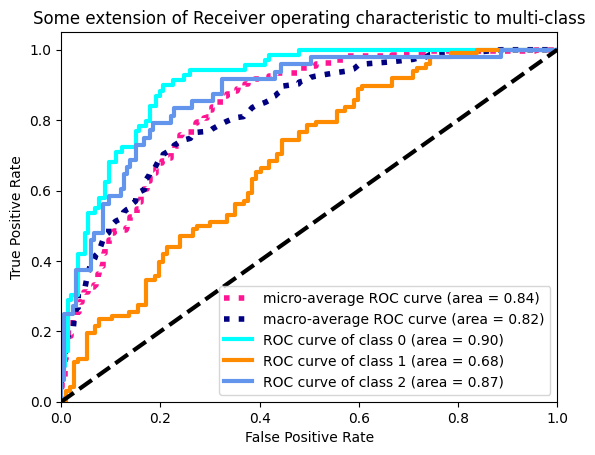

AB


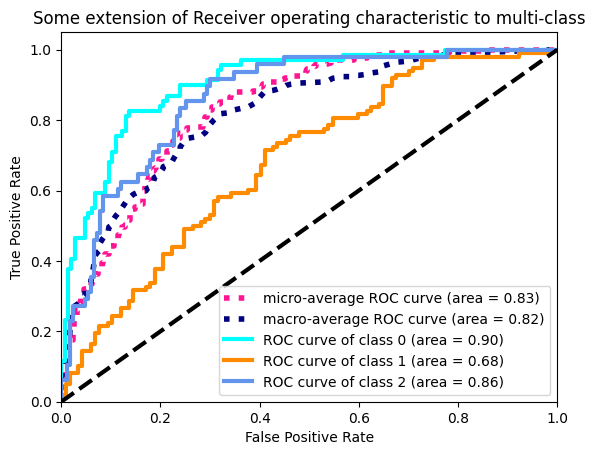

RF


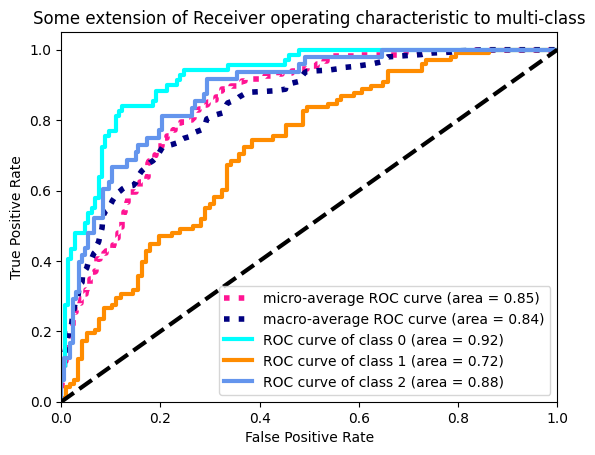

GB


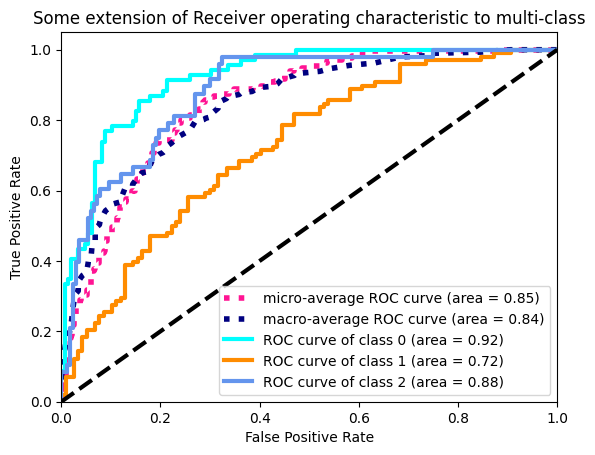

SVM


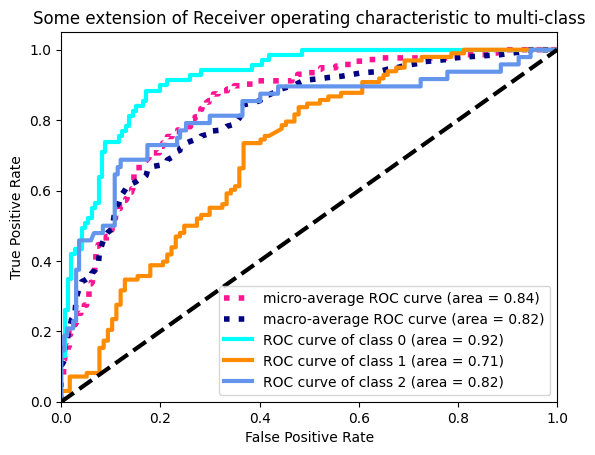

Tree


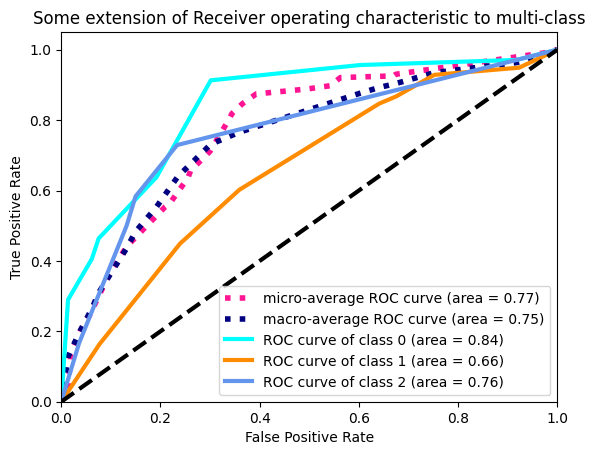

SGD


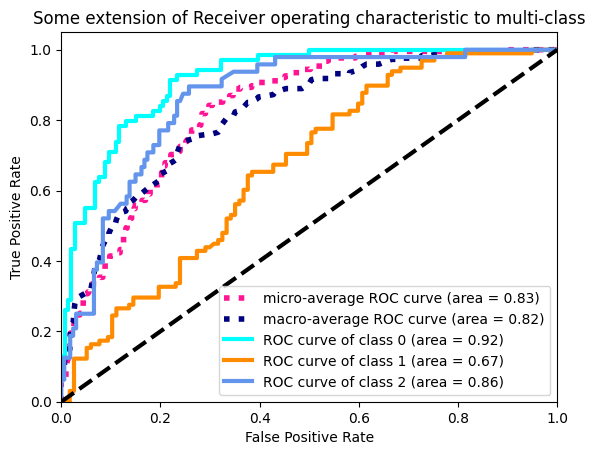

SVC


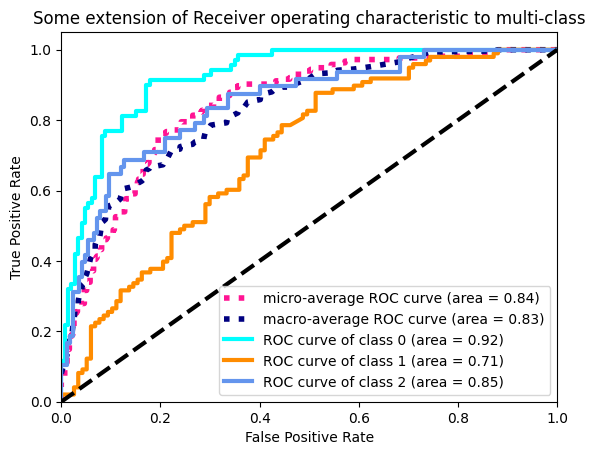

In [650]:
from sklearn.metrics import accuracy_score
from itertools import cycle

def plot_multi_class_ROC_Curve(fitted_models):    
    # print test scores
    n_classes = pre_test_y.shape[1]
    for name, model in fitted_models.items():
        print(name)
        predALL_y = model.predict_proba(test_X)
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(pre_test_y[:, i], predALL_y[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(pre_test_y.ravel(), predALL_y.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        lw = 3
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
        
plot_multi_class_ROC_Curve(fitted_models_hrisk)

In the above plots we are able to observe each model performance:

- each of the 3 classes
- average micro and macro ROC curves

Based on the results the best model seems to be the RF and GB who have the same scores:

- micro-average ROC curve: 0.85
- macro-average ROC curve: 0.84
- class 0: 0.92
- class 1: 0.72
- class 2: 0.88

## ii) SAVRY baseline model

To predict recidivism, the SAVRY score can be treated as a feature in a binary classification problem. A logistic regression model can be trained using the SAVRY score as a feature, along with other relevant features, to predict the probability of recidivism. The logistic regression model can then be used to classify a new individual as likely to recidivate or not, based on their SAVRY score and other relevant features.

In summary, the SAVRY score can be used as a feature in a logistic regression model for predicting recidivism, which is a binary classification problem.

In [1006]:
train_y_savry = train["V60_SAVRY_total_score"]
test_y_savry = test["V60_SAVRY_total_score"]

savry_model = LogisticRegression(solver='liblinear')

savry_model.fit(train_X,train_y_savry)

LogisticRegression(solver='liblinear')

In [1007]:
savry_model.score(test_X,test_y_SAVRY)

0.05116279069767442

We are getting a score of around 5% for testing, which didn't expected to be so low and shows extremely poor performance of the SAVRY Baseline model.

### Questions

<b>1. Which are the top ten most important features of each model?</b>

### Human Risk Assessment

In [969]:
feat_impts = []
for name, model in fitted_models_hrisk.items():
    if name == 'RF':
        best_model = model.best_estimator_
        estimators = best_model.named_steps['onevsrestclassifier'].estimators_
        feat_impts.extend([estimator.feature_importances_ for estimator in estimators])


In [960]:
#feat_impts = []
#for name, model in fitted_models.items():
#    if name == 'RF':
#        best_model = model.best_estimator_
#        estimators = best_model.named_steps['randomforestclassifier'].estimators_
#        feat_impts.extend([estimator.feature_importances_ for estimator in estimators])


In [970]:
mean = np.mean(feat_impts, axis=0)
pd.DataFrame(mean*10,index=test_X.columns,columns=["Importance"]).sort_values("Importance",ascending=False)[:10]

,Importance
V81_@17_actitud_negatives_Baix,0.528473
V81_@17_actitud_negatives_Alt,0.381967
V82_@18_assumpcio_riscos_impulsivitat_Alt,0.327898
V81_@17_actitud_negatives_Moderat,0.295851
V75_@11_delinquencia_grup_iguals_Baix,0.292257
V84_@20_problemes_maneig_enuig_Baix,0.292118
V75_@11_delinquencia_grup_iguals_Alt,0.291917
V85_@21_baix_nivell_empatia_remordiment_Baix,0.235718
V93_@P5_fort_compromis_escola_treball_Absent,0.231439
V20_nombre_antecedents,0.220785


### <u>Comment</u>

We notice that the most important feature of the RF model for the human risk assessment category is if the individual had a lower number of negative attitudes. Furthermore, it is noteworthy that the number of "records" (antecedents) is in 10th place, while in the first RF model of Exercice 1 this feature was at the first place of importance.

### SAVRY

Previously we created the LogisticRegression model for SAVRY. With Logistic Regression we have to look at the coefficients, thanks to the .coef_() method.

In [883]:
mean = np.mean(savry_model.coef_, axis=0)
pd.DataFrame(mean*10,index=test_X.columns,columns=["Importance"]).sort_values("Importance",ascending=False)[:10]

,Importance
V83_@19_problemes_consum_toxics_Moderat,0.229444
V73_@9_separacio_precoç_pares_Alt,0.168478
V79_@15_manca_suport_personal_social_Alt,0.121022
V74_@10_baix_rendiment_escola_Alt,0.113767
V65_@1_violencia_previa_Alt,0.092689
V86_@22_problemes_concentracio_hiperactivitat_Baix,0.062893
V78_@14_escassa_habilitat_pares_educar_Moderat,0.052357
V15_fet_agrupat_Contra les persones,-0.019202
V71_@7_historia_maltracte_infantil_Baix,-0.019208
V69_@5_intents_autolesio_suicidi_anteriors_Alt,-0.092126


<b>2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?</b>

In [975]:
import pandas as pd

RFImportance = list(zip(fitted_models_ebr['RF'].best_estimator_.named_steps['randomforestclassifier'].feature_importances_, train_X))
RFImportance.sort(reverse=True)

df = pd.DataFrame(RFImportance, columns=['Importance', 'Feature'])

df.head(10)

,Importance,Feature
0,0.060926,V1_sexe_Dona
1,0.048711,V1_sexe_Home
2,0.048335,V79_@15_manca_suport_personal_social_Alt
3,0.045428,V20_nombre_antecedents
4,0.036014,V8_edat_fet
5,0.025794,V80_@16_entorn_marginal_Baix
6,0.024635,V80_@16_entorn_marginal_Alt
7,0.018901,V75_@11_delinquencia_grup_iguals_Alt
8,0.017983,V81_@17_actitud_negatives_Baix
9,0.014949,V79_@15_manca_suport_personal_social_Moderat


We can see that the gender feature plays the most important role in this case. On fourth place we have the number of prior offenses or criminal history of the young offender, in the fifth place V8_edat_fet is a variable in the SAVRY dataset that represents the age of the offender at the time of the offense, which is a critical feature.

To sum up, after exploring different machine learning models, we observed that each model has its own way of computing feature importance, which is influenced by various factors such as the type of the algorithm and the amount of data available. In the case of the EBR random forest model, we noticed that the feature importance changed significantly when we used a larger dataset. This highlights the importance of understanding the limitations and assumptions of the machine learning models being used, and the need to combine the expertise of human experts with machine learning techniques to make informed decisions. Therefore, it is essential to consider the use of machine learning as a tool that can aid human experts, rather than relying solely on these models to make critical decisions.